In [1]:
import sys
import os
import distutils.core
import torch
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import math
import matplotlib.pyplot as plt
import random
from pycocotools.coco import COCO
import cv2 
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

/home/neru/M5/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
#load dataset
annotations_path = "./annotations/instances_val2017.json"
annotations_train_path = "./annotations/instances_train2017.json"
database_path = "./val2017/"
coco_annotation=COCO(annotations_path)
coco_annotation_train = COCO(annotations_train_path)
 
 

loading annotations into memory...
Done (t=14.15s)
creating index...
index created!
loading annotations into memory...
Done (t=96.61s)
creating index...
index created!


In [ ]:
def load_random_image(annotations, database_path):

    random_img_filename = random.choice(os.listdir(database_path)) #change dir and pick random image
    random_img = cv2.imread(database_path+random_img_filename)  #read image
    random_img_id = int(random_img_filename.split('.')[0])  #get id

    random_annotation_ids = annotations.getAnnIds(imgIds=random_img_id)   #get annotations (list of all gt detections in image)
    random_annotation_id = random_annotation_ids[random.randint(0, len(random_annotation_ids)-1)]   #pick 1
    random_annotation_img  = annotations.loadAnns(random_annotation_id)
    random_mask= annotations.annToMask(random_annotation_img[0])
    
    print("Random image filename: ",random_img_filename)
    print("Random image annotations" ,random_annotation_img)
    return random_img, random_mask

def load_image_and_annotations(img_filename, database_path):
    img = cv2.imread(database_path+img_filename)
    img_id = int(img_filename.split('.')[0])
    info = coco_annotation.loadImgs([img_id])
    return img, info




Random image filename:  000000345252.jpg
Random image annotations [{'segmentation': [[518.96, 479.0, 573.1, 479.0, 563.63, 455.1, 557.54, 439.53, 563.63, 420.58, 615.73, 331.26, 627.24, 297.42, 619.12, 290.66, 602.87, 294.72, 586.63, 323.14, 562.27, 382.69, 562.95, 394.87, 552.12, 413.82, 513.55, 479.0]], 'area': 5109.288949999998, 'iscrowd': 0, 'image_id': 345252, 'bbox': [513.55, 290.66, 113.69, 188.34], 'category_id': 62, 'id': 101725}]
Target image:  000000160728.jpg


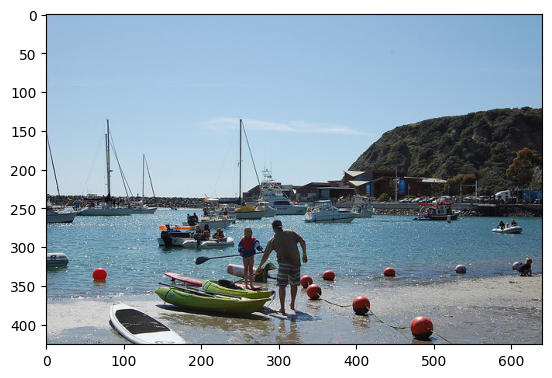

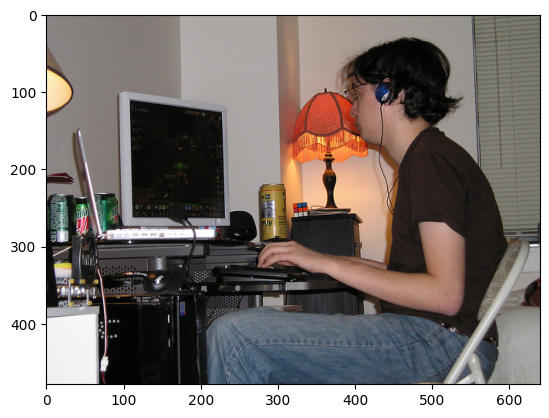

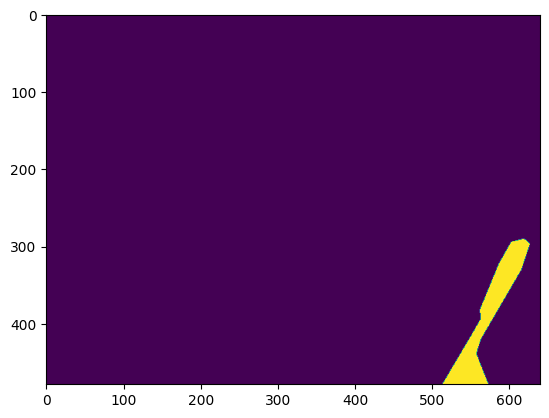

In [ ]:
#load main image
img1_filename = random.choice(os.listdir(database_path)) #pick randomly or select a filename
img1, info_img1 = load_image_and_annotations(img1_filename, database_path)
img1_h, img1_w, img1_chann = img1.shape

#load random image
img2, random_mask_img2 = load_random_image(coco_annotation, database_path)

plt.figure()
plt.imshow(img1[:,:,::-1])
plt.figure()
plt.imshow(img2[:,:,::-1])
plt.figure()
plt.imshow(random_mask_img2)

print("Target image: ",img1_filename)

im = img1.copy()


In [ ]:
def pad_image(img, new_image_height, new_image_width):
    
    color = (0,0,0)


    
    if len(img.shape)==3:
        old_image_height, old_image_width, channels = img.shape
        
    if len(img.shape)==2:
        old_image_height, old_image_width = img.shape
        

    if old_image_height>new_image_height:
        img = img[math.floor((old_image_height-new_image_height)/2):-math.ceil((old_image_height-new_image_height)/2),:]
        old_image_height = new_image_height
    if old_image_width>new_image_width:
        img = img[:,math.floor((old_image_width-new_image_width)/2):-math.ceil((old_image_width-new_image_width)/2)]
        old_image_width = new_image_width
    
    
    if len(img.shape)==3:
        old_image_height, old_image_width, channels = img.shape
        
        result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)
    if len(img.shape)==2:
        old_image_height, old_image_width = img.shape
        result = np.full((new_image_height,new_image_width), 0, dtype=np.uint8)

    
    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    # copy img image into center of result image
    result[y_center:y_center+old_image_height, 
        x_center:x_center+old_image_width] = img

    return result
def transplant_images(image_1, image_2,image_2_mask):

    image_1_copy = image_1.copy() 

    #--- Copy pixel values of logo image to room image wherever the mask is white ---
    image_1_copy[np.where(image_2_mask == 1)] = image_2[np.where(image_2_mask == 1)]

    return image_1_copy

def apply_transformation(img, tx,ty, angle, scale):
    
    # Rotate the image using cv2.warpAffine()
    M = cv2.getRotationMatrix2D((ty, tx), angle, scale)
    warped_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return warped_img



NEW  426 W  640
OLD  479 W  479
OLD AFTER  426 W  640
NEW  426 W  640
OLD  479 W  479
OLD AFTER  426 W  640


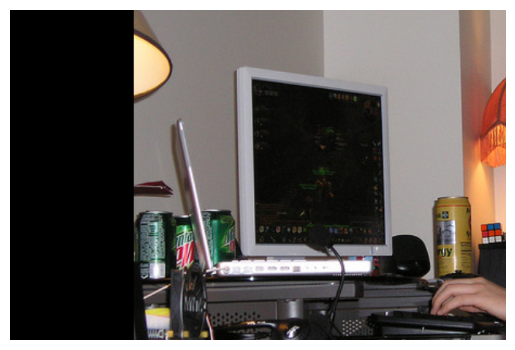

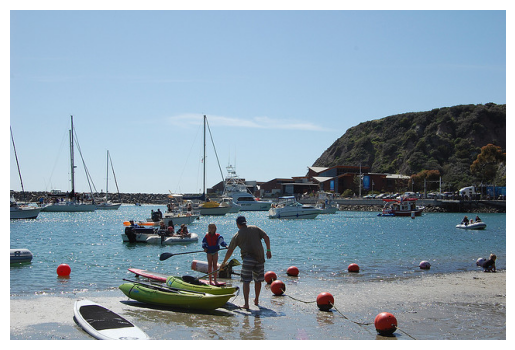

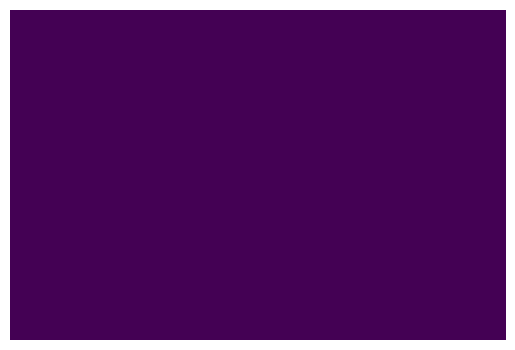

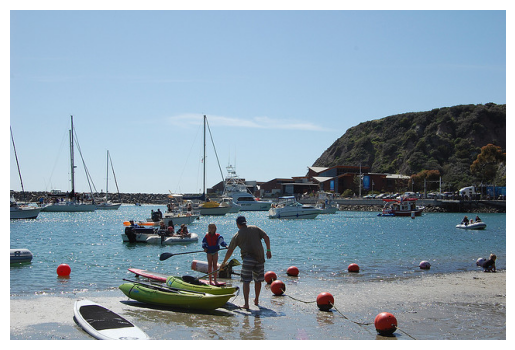

In [ ]:
tx =100
ty = -400
rotation_angle_deg = 0
scale = 1.4
warped_image = apply_transformation(img2,tx, ty,rotation_angle_deg, scale)
warped_mask =  apply_transformation(random_mask_img2,tx, ty,rotation_angle_deg, scale)

warped_image =  pad_image(warped_image,img1_h, img1_w)
warped_mask =  pad_image(warped_mask,img1_h, img1_w)

plt.figure(frameon=False)

plt.axis('off')
plt.imshow(warped_image[:,:,::-1])
plt.figure(frameon=False)
plt.axis('off')
plt.imshow(img1[:,:,::-1])
plt.figure(frameon=False)

plt.axis('off')
plt.imshow(warped_mask[:,:])
new_image =  transplant_images(img1, warped_image,warped_mask)

plt.figure(frameon=False)

plt.axis('off')
plt.imshow(new_image[:,:,::-1])


In [ ]:
cfg = get_cfg()
model = 'mask_rcnn'
if model == 'mask_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
elif model == 'fast_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

[03/25 11:47:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [ ]:
def predict(predictor, img):
    outputs = predictor(img)
    output_predictions = outputs["instances"].pred_classes

    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    output_image= out.get_image()
    return output_image, output_predictions

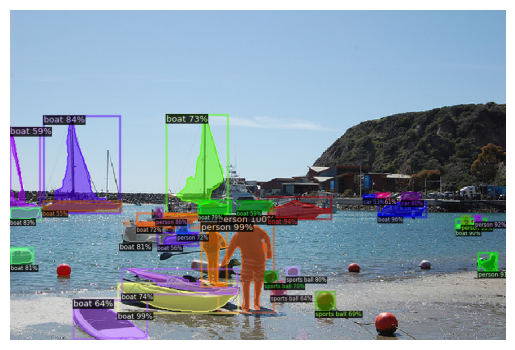

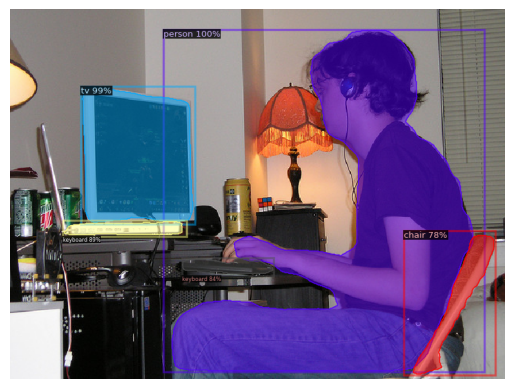

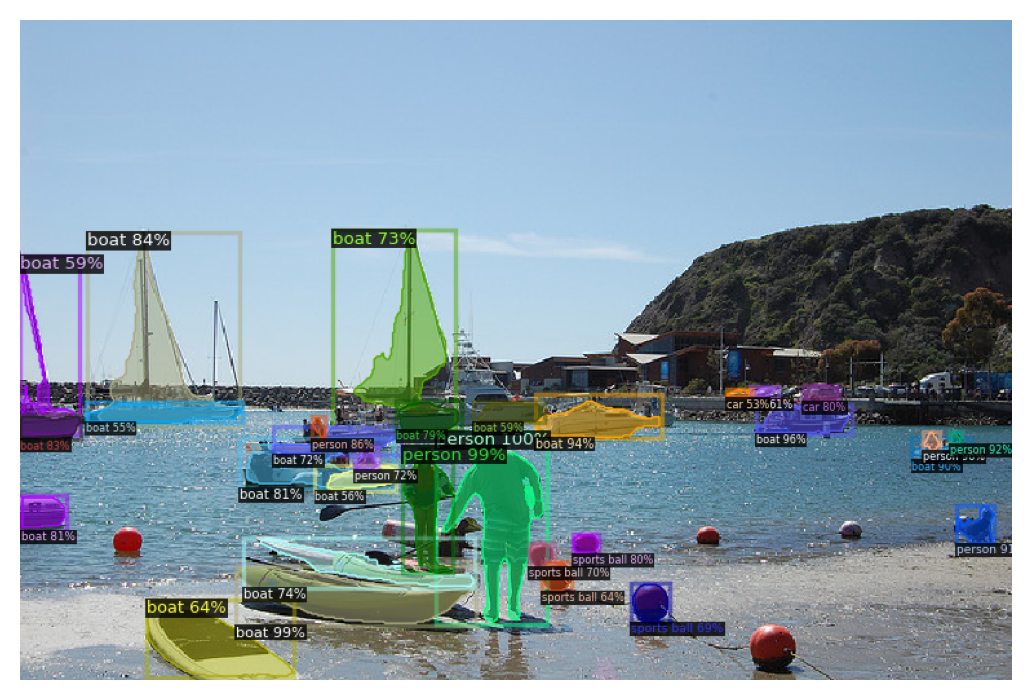

In [ ]:

output_image_1, _ = predict(predictor, img1)

plt.figure(frameon=False)
plt.axis('off')
plt.imshow(output_image_1)

output_image_2, _ = predict(predictor, img2)

plt.figure(frameon=False)
plt.axis('off')
plt.imshow(output_image_2)

output_new_image, _ = predict(predictor,new_image)

plt.figure(frameon=False, dpi=200)
plt.axis('off')
plt.imshow(output_new_image)

In [ ]:
#get all ids
image_ids = coco_annotation_train.getImgIds()

# get categories
category_ids = coco_annotation_train.getCatIds()
num_category_ids = len(category_ids)

# initialize co-occurrence matrix
coocurrence_matrix_original = np.zeros([91,91])

# for each image in our database
for image_id in image_ids:
    # load annotations
    annotations = coco_annotation_train.loadAnns(coco_annotation_train.getAnnIds(imgIds=image_id))

    # extract IDs for the annotations
    annotation_category_ids = [annotation['category_id'] for annotation in annotations]
    
    # increment co-occurrence if theyre both in the same image
    for category_id_i in category_ids:
        for category_id_j in category_ids:
            if category_id_i in annotation_category_ids and category_id_j in annotation_category_ids:
                
                coocurrence_matrix_original[category_id_i-1,category_id_j-1] = coocurrence_matrix_original[category_id_i-1,category_id_j-1] + 1
                


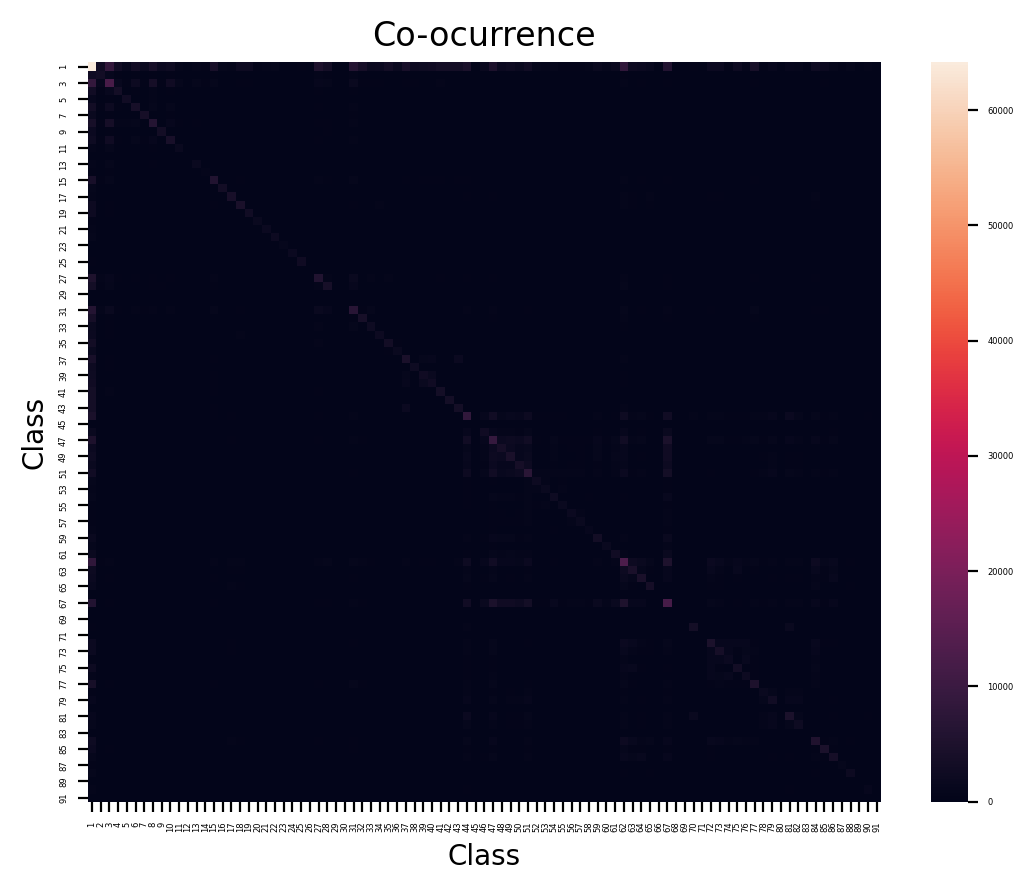

In [ ]:
coocurrence_matrix = coocurrence_matrix_original.copy()
np.fill_diagonal(coocurrence_matrix, 0, wrap=False) #set to 0 so we dont considerate instances of the same class

plt.figure(frameon=False, dpi=200)
mpl.rc('xtick', labelsize=3) 
mpl.rc('ytick', labelsize=3) 
sns.heatmap(coocurrence_matrix)

class_array = np.linspace(1, 91, num=91).astype(int)
# creating the dataframe
df = pd.DataFrame(data = coocurrence_matrix_original, 
                  index =class_array, 
                  columns = class_array)

plt.clf() # clear figure 
sns.heatmap(df).set(xlabel='Class',
       ylabel='Class',title='Co-ocurrence')
plt.show()

In [ ]:
def retrieve_img_mask_given_id(class_id, database_path, annotations):
    imgIds = annotations.getImgIds(catIds=[class_id])
    # chose random image containing class id
    imgId = random.choice(imgIds)
    print("ID ", imgId)
    # load annotations of said image
    annIds = annotations.getAnnIds(imgIds=imgId, catIds=class_id, iscrowd=None)
    anns = annotations.loadAnns(annIds)
    #read image and convert mask to array
    retrieved_img = cv2.imread(database_path+str(imgId).zfill(12)+".jpg")  #read image
    retrieved_mask= annotations.annToMask(anns[0])
    return retrieved_img, retrieved_mask

Excluding:  (array([11, 25, 28, 29, 44, 65, 67, 68, 70, 82, 90]),)
Input class: bicycle (id  2 )
Class with highest co-occurrency: person (id  1 )
Class with lowest  co-occurrency: hair drier (id  89 )
ID  122166
ID  25181
ID  239041


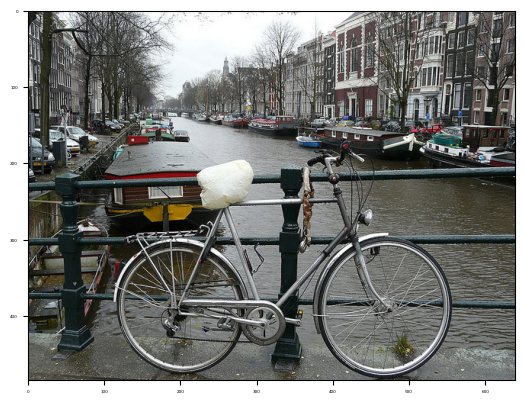

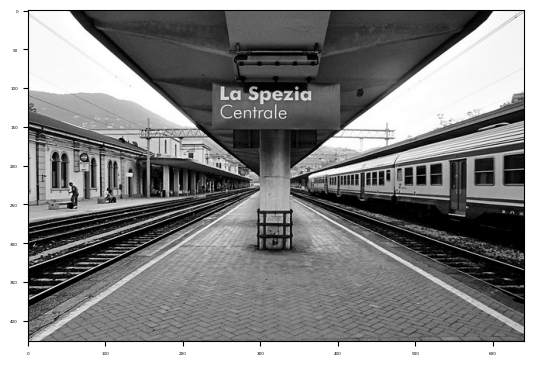

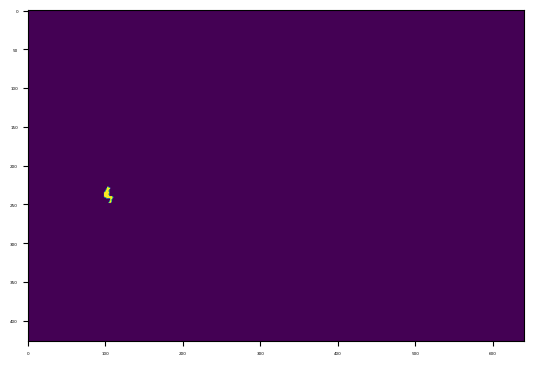

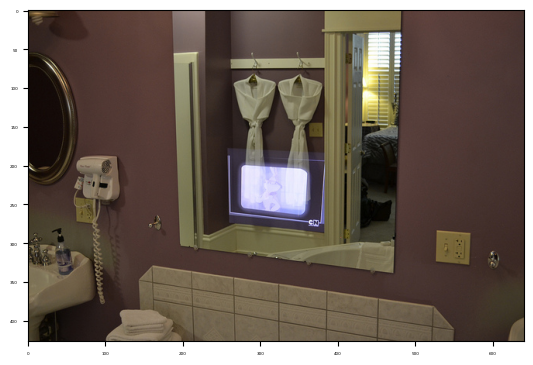

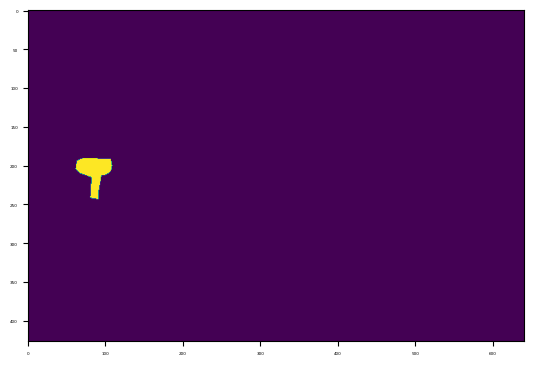

In [ ]:
#select random image but now taking into account a specific class
input_string = 'bicycle'
input_class = coco_annotation.getCatIds(catNms=[input_string])[0]-1
excluded_indices = np.asarray(coocurrence_matrix_original[0]== 0).nonzero()
print("Excluding: ", excluded_indices)
#mask excluded classes
mask= np.zeros(coocurrence_matrix[input_class].size, dtype=bool)
mask[input_class] = True
mask[excluded_indices] = True
masked_array = np.ma.array(coocurrence_matrix[input_class], mask=mask)
print("Input class:", input_string,"(id ", input_class+1, ")")


#get maximum coocurrency
max_occurrences_class = np.argmax(masked_array)+1
most_cooc_string = coco_annotation.loadCats([max_occurrences_class])[0]['name']
print("Class with highest co-occurrency:", most_cooc_string, "(id ", max_occurrences_class, ")")

#get minimum coocurrency
min_occurrences_class = np.argmin(masked_array)+1
least_cooc_string = coco_annotation.loadCats([min_occurrences_class])[0]['name']
print("Class with lowest  co-occurrency:", least_cooc_string, "(id ", min_occurrences_class, ")")

#load random image of specified class
input_img, _ = retrieve_img_mask_given_id(input_class+1, database_path, coco_annotation)
plt.figure(frameon=False)
plt.imshow(input_img[:,:,::-1])

max_cooc_img, max_cooc_img_mask = retrieve_img_mask_given_id(max_occurrences_class, database_path, coco_annotation)
plt.figure(frameon=False)
plt.imshow(max_cooc_img[:,:,::-1])
plt.figure(frameon=False)
plt.imshow(max_cooc_img_mask)


min_cooc_img, min_cooc_img_mask = retrieve_img_mask_given_id(min_occurrences_class, database_path, coco_annotation)
plt.figure(frameon=False)
plt.imshow(min_cooc_img[:,:,::-1])
plt.figure(frameon=False)
plt.imshow(min_cooc_img_mask)




NEW  485 W  640
OLD  427 W  427
OLD AFTER  427 W  640
NEW  485 W  640
OLD  427 W  427
OLD AFTER  427 W  640
NEW  485 W  640
OLD  427 W  427
OLD AFTER  427 W  640
NEW  485 W  640
OLD  427 W  427
OLD AFTER  427 W  640


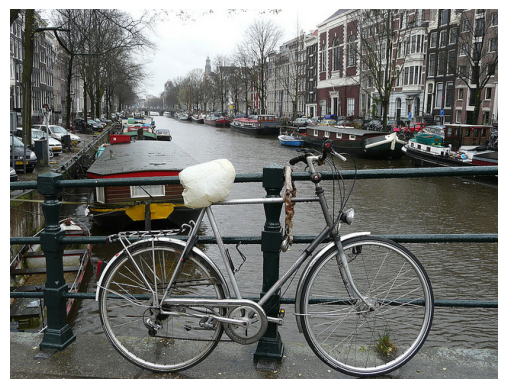

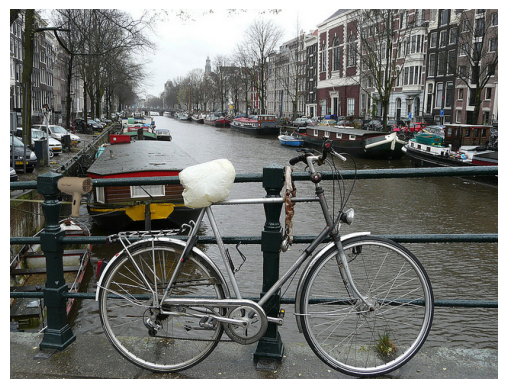

In [ ]:
tx =0
ty = 0
rotation_angle_deg = 0
scale = 1
input_h, input_w,_ = input_img.shape
warped_image_max = apply_transformation(max_cooc_img,tx, ty,rotation_angle_deg, scale)
warped_mask_max =  apply_transformation(max_cooc_img_mask,tx, ty,rotation_angle_deg, scale)

warped_image_max =  pad_image(warped_image_max,input_h, input_w)
warped_mask_max =  pad_image(warped_mask_max,input_h, input_w)

transplant_max =  transplant_images(input_img, warped_image_max,warped_mask_max)

plt.figure(frameon=False)

plt.axis('off')
plt.imshow(transplant_max[:,:,::-1])

input_h, input_w,_ = input_img.shape
warped_image_min = apply_transformation(min_cooc_img,tx, ty,rotation_angle_deg, scale)
warped_mask_min =  apply_transformation(min_cooc_img_mask,tx, ty,rotation_angle_deg, scale)

warped_image_min =  pad_image(warped_image_min,input_h, input_w)
warped_mask_min =  pad_image(warped_mask_min,input_h, input_w)

transplant_min =  transplant_images(input_img, warped_image_min,warped_mask_min)

plt.figure(frameon=False)

plt.axis('off')
plt.imshow(transplant_min[:,:,::-1])


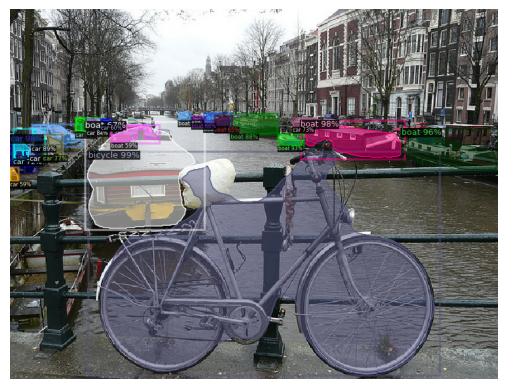

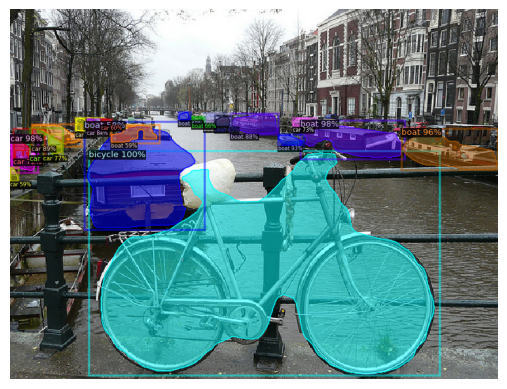

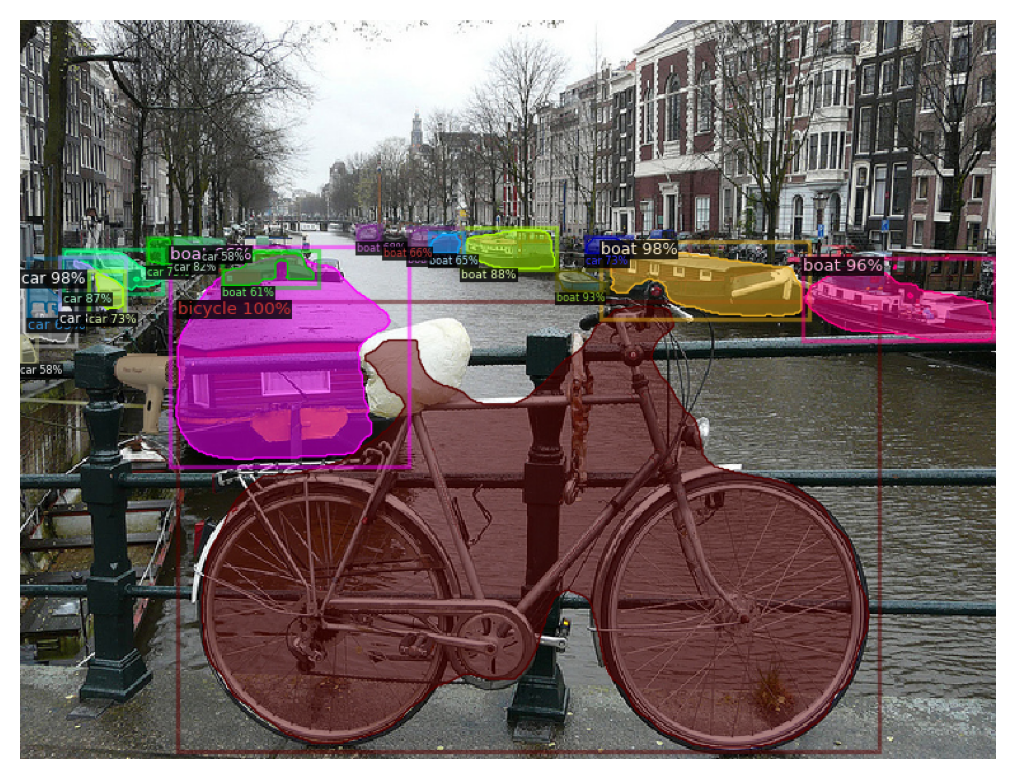

In [ ]:

output_image_1conc, _ = predict(predictor, input_img)    

plt.figure(frameon=False)
plt.axis('off')
plt.imshow(output_image_1conc)

output_image_transplant_max, _ = predict(predictor, transplant_max)

plt.figure(frameon=False)
plt.axis('off')
plt.imshow(output_image_transplant_max)

output_image_transplant_min, _ = predict(predictor,transplant_min)

plt.figure(frameon=False, dpi=200)
plt.axis('off')
plt.imshow(output_image_transplant_min)

In [ ]:
print("PERSON BICYCLE COOCCURRENCY",coocurrence_matrix_original[1][0])
print("HAIR DRIER BICYCLE COOCCURRENCY",coocurrence_matrix_original[1][88])
print("BIRD BICYCLE COOCCURRENCY",coocurrence_matrix_original[1][15])
print("CAT BICYCLE COOCCURRENCY",coocurrence_matrix_original[1][16])
print("SHEEP BICYCLE COOCCURRENCY",coocurrence_matrix_original[1][19])

PERSON BICYCLE COOCCURRENCY 2643.0
HAIR DRIER BICYCLE COOCCURRENCY 0.0
BIRD BICYCLE COOCCURRENCY 63.0
CAT BICYCLE COOCCURRENCY 71.0
SHEEP BICYCLE COOCCURRENCY 10.0
